In [787]:
from IPython.display import display

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from functools import wraps
from omegaconf import OmegaConf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

Load config file

In [678]:
def with_config(config_name):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            with open(f"../config/{config_name}", "rb") as f:
                cfg = OmegaConf.load(f)
            config = cfg
            return func(config, *args, **kwargs)
        return wrapper
    return decorator

Initial data preparation

In [679]:
@with_config("main.yaml")
def load_data(cfg) -> pd.DataFrame:
    """This funtion loads the data in a pandas DataFrame"""
    return pd.read_csv(cfg.data.raw)

In [680]:
load_data().head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [681]:
df = load_data()

In [682]:
df['Churn']

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
7038     No
7039     No
7040     No
7041    Yes
7042     No
Name: Churn, Length: 7043, dtype: object

In [683]:
def number_of_rows() -> int:
    """This function returns the number of rows in the dataframe"""
    return len(load_data())

In [684]:
number_of_rows()

7043

In [685]:
def column_transpose() -> pd.DataFrame:
    """This function gives an overview of the columns and values the represent"""
    return df.head().T

In [686]:
column_transpose()

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [687]:
def check_column_type() -> pd.Series:
    """This function checks the value data types contained in the different columns"""
    return df.dtypes

In [688]:
check_column_type()

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [689]:
total_charges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [690]:
df[total_charges.isnull()][['customerID', 'TotalCharges']]

,customerID,TotalCharges
488,4472-LVYGI,
753,3115-CZMZD,
936,5709-LVOEQ,
1082,4367-NUYAO,
1340,1371-DWPAZ,
3331,7644-OMVMY,
3826,3213-VVOLG,
4380,2520-SGTTA,
5218,2923-ARZLG,
6670,4075-WKNIU,


In [691]:
def fill_missing_total_charge() -> None:
    """This function fills the empty spaces with NAN in the Total charge column"""
    df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
    df.TotalCharges = df.TotalCharges.fillna(0)

In [692]:
fill_missing_total_charge()

In [693]:
def make_columns_uniform() -> None:
    """This function makes column names lowercase and replaces spaces with underscore"""
    df.columns = df.columns.str.lower().str.replace(" ", "_")

In [694]:
make_columns_uniform()

In [695]:
def make_values_uniform() -> None:
    """This function makes all string value lowercase and replaces spaces with underscore"""
    string_columns = list(df.dtypes[df.dtypes == 'object'].index)
    for col in string_columns:
        df[col] = df[col].str.lower().str.replace(" ", "_")

In [696]:
make_values_uniform()

In [697]:
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [698]:
@with_config("main.yaml")
def encode_target_variable(config) -> None:
    """This function encodes the target variable into boolean 1 and 0 for yes and no values respectively"""
    df.churn = (df[config.churn.target] == "yes").astype(int)

In [699]:
encode_target_variable()

In [700]:
df.churn

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: churn, Length: 7043, dtype: int64

split data

In [701]:
len(df)

7043

In [702]:
def split_data() -> None:
    """This function splits data into training, validation and test sets"""
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
    df_train, df_val = train_test_split(df_full_train, test_size=0.33, random_state=1)
    return df_full_train, df_train, df_val, df_test

In [703]:
df_full_train, df_train, df_val, df_test = split_data()

In [704]:
df_train['churn'].values

array([0, 1, 0, ..., 1, 0, 1])

In [705]:
@with_config('main.yaml')
def extract_target(config) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Thisfunction extracts the target variable from the df and resturns it as separate arrays"""
    y_train = df_train[config.churn.target].values
    y_val = df_val[config.churn.target].values
    y_test = df_test[config.churn.target].values
    return y_train, y_val, y_test

In [706]:
y_train, y_val, y_test = extract_target()

In [707]:
@with_config("main.yaml")
def remove_target(config) -> None:
    """This function removes the target variable from the df"""
    del df_train[config.churn.target]
    del df_val[config.churn.target]
    del df_test[config.churn.target]

In [708]:
remove_target()

Exploratory data analysis

In [709]:
# check missing values
df_full_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [710]:
# Propotion of target variable
len(df_full_train[df_full_train.churn==1])

1521

In [711]:
df_full_train.churn.mean()

0.26996805111821087

In [712]:
categoricals = list(df_full_train.dtypes[df_full_train.dtypes=="object"].index)

In [713]:
categoricals.append('seniorcitizen')

In [714]:
categoricals

['customerid',
 'gender',
 'partner',
 'dependents',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'seniorcitizen']

In [715]:
categoricals.remove('customerid')

In [716]:
df_full_train[categoricals].columns

Index(['gender', 'partner', 'dependents', 'phoneservice', 'multiplelines',
       'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'contract',
       'paperlessbilling', 'paymentmethod', 'seniorcitizen'],
      dtype='object')

In [717]:
list(df_full_train.columns.difference(categoricals))

['churn', 'customerid', 'monthlycharges', 'tenure', 'totalcharges']

In [718]:
numericals = list(df_full_train.columns.difference(categoricals))


In [719]:
df_full_train[categoricals].nunique()

gender              2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
seniorcitizen       2
dtype: int64

Feature importance analysis

Churn rate
 

In [720]:
global_churn = df_full_train.churn.mean()
round(global_churn, 3)

0.27

In [721]:
female_churn = df_full_train.churn[df_full_train.gender == 'female'].mean()

print("female_churn:", round(female_churn, 3))

male_churn = df_full_train.churn[df_full_train.gender == 'male'].mean()

print("male_churn:", round(male_churn, 3))

partner_yes = df_full_train.churn[df_full_train.partner == 'yes'].mean()

print("partner_yes:", round(partner_yes, 3))
partner_no = df_full_train.churn[df_full_train.partner == 'no'].mean()

print("partner_no:", round(partner_no, 3))

female_churn: 0.277
male_churn: 0.263
partner_yes: 0.205
partner_no: 0.33


Risk ratio

In [722]:
gloabal_mean = df_full_train.churn.mean()

In [723]:
df_group = df_full_train.groupby(by='gender').churn.agg(['mean'])

In [724]:
df_group['diff'] = df_group - gloabal_mean

In [725]:
df_group['risk'] = df_group['mean'] / gloabal_mean

In [726]:
df_group

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


In [727]:
for col in categoricals:
    df_group = df_group = df_full_train.groupby(by=col).churn.agg(['mean'])
    df_group['diff'] = df_group - gloabal_mean
    df_group['risk'] = df_group['mean'] / gloabal_mean
    display(df_group)

,mean,diff,risk
gender,,,
female,0.276824,0.006856,1.025396
male,0.263214,-0.006755,0.974980


,mean,diff,risk
partner,,,
no,0.329809,0.059841,1.221659
yes,0.205033,-0.064935,0.759472


,mean,diff,risk
dependents,,,
no,0.313760,0.043792,1.162212
yes,0.165666,-0.104302,0.613651


,mean,diff,risk
phoneservice,,,
no,0.241316,-0.028652,0.893870
yes,0.273049,0.003081,1.011412


,mean,diff,risk
multiplelines,,,
no,0.257407,-0.012561,0.953474
no_phone_service,0.241316,-0.028652,0.893870
yes,0.290742,0.020773,1.076948


,mean,diff,risk
internetservice,,,
dsl,0.192347,-0.077621,0.712482
fiber_optic,0.425171,0.155203,1.574895
no,0.077805,-0.192163,0.288201


,mean,diff,risk
onlinesecurity,,,
no,0.420921,0.150953,1.559152
no_internet_service,0.077805,-0.192163,0.288201
yes,0.153226,-0.116742,0.567570


,mean,diff,risk
onlinebackup,,,
no,0.404323,0.134355,1.497672
no_internet_service,0.077805,-0.192163,0.288201
yes,0.217232,-0.052736,0.804660


,mean,diff,risk
deviceprotection,,,
no,0.395875,0.125907,1.466379
no_internet_service,0.077805,-0.192163,0.288201
yes,0.230412,-0.039556,0.853480


,mean,diff,risk
techsupport,,,
no,0.418914,0.148946,1.551717
no_internet_service,0.077805,-0.192163,0.288201
yes,0.159926,-0.110042,0.592390


,mean,diff,risk
streamingtv,,,
no,0.342832,0.072864,1.269897
no_internet_service,0.077805,-0.192163,0.288201
yes,0.302723,0.032755,1.121328


,mean,diff,risk
streamingmovies,,,
no,0.338906,0.068938,1.255358
no_internet_service,0.077805,-0.192163,0.288201
yes,0.307273,0.037305,1.138182


,mean,diff,risk
contract,,,
month-to-month,0.431701,0.161733,1.599082
one_year,0.120573,-0.149395,0.446621
two_year,0.028274,-0.241694,0.104730


,mean,diff,risk
paperlessbilling,,,
no,0.172071,-0.097897,0.637375
yes,0.338151,0.068183,1.252560


,mean,diff,risk
paymentmethod,,,
bank_transfer_(automatic),0.168171,-0.101797,0.622928
credit_card_(automatic),0.164339,-0.105630,0.608733
electronic_check,0.455890,0.185922,1.688682
mailed_check,0.193870,-0.076098,0.718121


,mean,diff,risk
seniorcitizen,,,
0,0.242270,-0.027698,0.897403
1,0.413377,0.143409,1.531208


Mutual information

In [728]:
def calculate_mi(series) -> pd.Series:
    """This function calculated the mutual information score between variables"""
    return mutual_info_score(series, df_full_train.churn)

In [729]:
df_mi = df_full_train[categoricals].apply(calculate_mi)

In [730]:
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

In [731]:
df_mi

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


Measure correlation for numerical variable

In [732]:
numericals.remove('customerid')

In [733]:
df_full_train[numericals]

,churn,monthlycharges,tenure,totalcharges
1814,0,19.70,12,258.35
5946,1,73.90,42,3160.55
3881,0,65.15,71,4681.75
2389,0,85.45,71,6300.85
3676,0,70.40,30,2044.75
...,...,...,...,...
905,1,100.50,9,918.60
5192,0,19.95,60,1189.90
3980,1,105.70,28,2979.50
235,1,54.40,2,114.10


In [734]:
df_full_train[numericals].corrwith(df_full_train.churn)

churn             1.000000
monthlycharges    0.196805
tenure           -0.351885
totalcharges     -0.196353
dtype: float64

In [735]:
df_full_train.tenure

1814    12
5946    42
3881    71
2389    71
3676    30
        ..
905      9
5192    60
3980    28
235      2
5157    16
Name: tenure, Length: 5634, dtype: int64

In [736]:
train_dict = df_train.to_dict(orient='records')

In [737]:
dv = DictVectorizer(sparse=False)

In [738]:
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [739]:
X_train = dv.transform(train_dict)

In [740]:
X_train[0]

array([  1. ,   0. ,   0. , ...,   0. ,   5. , 408.5])

In [741]:
dv.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', ..., 'techsupport=yes', 'tenure',
       'totalcharges'], dtype=object)

In [742]:
y_train

array([0, 1, 0, ..., 1, 0, 1])

In [743]:
model = LogisticRegression(solver='liblinear', random_state=1)

In [744]:
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [745]:
numericals = [col for col in numericals if col not in ['churn', 'customerid']]

In [746]:
df_val_copy = df_val.copy()

In [747]:
df_val_copy = df_val_copy.drop('customerid', axis=1)

In [748]:
val_dict = df_val_copy.to_dict(orient='records')

In [749]:
X_val = dv.transform(val_dict)

In [750]:
X_val

array([[0.0000e+00, 0.0000e+00, 1.0000e+00, ..., 1.0000e+00, 7.1000e+01,
        4.9734e+03],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        2.0750e+01],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        2.0350e+01],
       ...,
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 3.0000e+00,
        2.2230e+02],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.0000e+01,
        1.9305e+02],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 1.2000e+01,
        2.2035e+02]])

In [751]:
y_pred = model.predict_proba(X_val)[:, 1]

In [752]:
churn = y_pred > 0.5

calculating the model accuracy

In [753]:
(churn == y_val).mean()

0.8059139784946237

Model intepretation

In [754]:
# Bias term
model.intercept_[0]

-0.10077239849636606

In [755]:
# Weights generated by the model
model.coef_[0]

array([ 5.35237743e-01, -6.87374655e-02, -5.67272676e-01, ...,
       -1.68500794e-01, -6.98855465e-02,  3.84821894e-04])

In [756]:
# Weighs generated by different features
dict(zip(dv.get_feature_names_out(), model.coef_[0]))

{'contract=month-to-month': 0.5352377433156302,
 'contract=one_year': -0.06873746550914847,
 'contract=two_year': -0.5672726763028277,
 'customerid=0002-orfbo': -0.006309454879863347,
 'customerid=0011-igkff': 0.007995813529351787,
 'customerid=0013-exchz': 0.009425967455697232,
 'customerid=0013-mhzwf': -0.009492991856445806,
 'customerid=0013-smeoe': -0.0021882640519176795,
 'customerid=0014-bmaqu': -0.0015756838097191438,
 'customerid=0015-uocoj': -0.010292575904201394,
 'customerid=0017-dinoc': -0.00041914933659520674,
 'customerid=0019-efaep': -0.0019733449201688874,
 'customerid=0020-inwck': -0.003082690388204935,
 'customerid=0020-jdnxp': -0.0018312050272426942,
 'customerid=0021-ikxgc': -0.0196767473492024,
 'customerid=0023-uyupn': -0.0005019161944720956,
 'customerid=0023-xuopt': 0.010352019882535434,
 'customerid=0030-fnxpp': -0.005054623077927788,
 'customerid=0031-pvlzi': 0.020079360326639036,
 'customerid=0036-ihmot': -0.0036484476018296286,
 'customerid=0042-rlhyp': -5.2

In [757]:
small_set = list(df_train[['contract', 'tenure', 'totalcharges']].columns)

In [758]:
dv_small = DictVectorizer(sparse=False)

In [759]:
train_dict_small = df_train[small_set].to_dict(orient='records')

In [760]:
dv_small.fit(train_dict_small)

DictVectorizer(sparse=False)

In [761]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'tenure', 'totalcharges'], dtype=object)

In [762]:
model_small = LogisticRegression(solver='liblinear', random_state=1)

In [763]:
X_train_small = dv.transform(train_dict_small)

In [764]:
model_small.fit(X_train_small, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [765]:
model_small.intercept_[0]

-0.4169872674883036

In [766]:
dict(zip(dv_small.get_feature_names_out(), model_small.coef_[0].round(3)))

{'contract=month-to-month': 0.624,
 'contract=one_year': -0.283,
 'contract=two_year': -0.758,
 'tenure': 0.0,
 'totalcharges': 0.0}

Using the model

In [767]:
customer = {
'customerid': '8879-zkjof',
'gender': 'female',
'seniorcitizen': 0,
'partner': 'no',
'dependents': 'no',
'tenure': 41,
'phoneservice': 'yes',
'multiplelines': 'no',
'internetservice': 'dsl',
'onlinesecurity': 'yes',
'onlinebackup': 'no',
'deviceprotection': 'yes',
'techsupport': 'yes',
'streamingtv': 'yes',
'streamingmovies': 'yes',
'contract': 'one_year',
'paperlessbilling': 'yes',
'paymentmethod': 'bank_transfer_(automatic)',
'monthlycharges': 79.85,
'totalcharges': 3320.75,
}

In [768]:
df_train_copy = df_train.copy()

In [769]:
del df_train_copy['customerid']

In [770]:
customer_one = df_train_copy.head(1).to_dict(orient='records')

In [771]:
X_customer_one = dv.transform(customer_one)

In [772]:
X_customer_one

array([[  1. ,   0. ,   0. , ...,   0. ,   5. , 408.5]])

In [775]:
score = model.predict_proba(X_customer_one)[0, 1]

In [776]:
if score >= 0.5:
    print("This customer will churn, send promotional email")
else:
    print("This is a loyal customer")

This customer will churn, send promotional email


#### Model Evaluation

In [792]:
y_pred = model.predict_proba(X_val)[:, 1]

In [801]:
churn = (y_pred >= 0.5)

In [786]:
accuracy_score = (y_val == churn).mean()
print(f"Accuracy Score:", accuracy_score)

Accuracy Score: 0.7311827956989247


In [790]:
threshold = np.linspace(0, 1, 11)

In [811]:
tiles = ['Threshold', 'Score']
print('%s %s' % (tiles[0], tiles[1]))
for t in threshold:
    churn = y_pred >= t
    acc = accuracy_score(y_val, churn)
    print('%0.2f %0.3f' % (t, acc))

tiles = ['Threshold', 'Score']



Threshold Score
0.00 0.269
0.10 0.574
0.20 0.687
0.30 0.746
0.40 0.776
0.50 0.806
0.60 0.800
0.70 0.763
0.80 0.734
0.90 0.731
1.00 0.731


In [815]:
accuracies = []
for t in threshold:
    churn = y_pred>=t
    acc = accuracy_score(y_val, churn)
    accuracies.append(acc)


Text(0.5, 1.0, 'Threshold vs Accuracy')

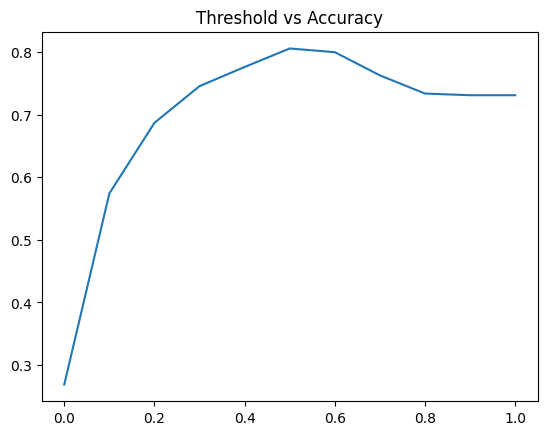

In [817]:
plt.plot(threshold, accuracies)
plt.title("Threshold vs Accuracy")

In [825]:
val_dict_small = df_val[small_set].to_dict(orient='records')

In [828]:
X_val_dict_small = dv.transform(val_dict_small)

In [843]:
val_dict_predict = model_small.predict_proba(X_val_dict_small)[:, 1]

In [844]:
val_pred = val_dict_predict >= 0.5

In [845]:
# Prediction score for small model
accuracy_score(y_val, val_pred)

0.774731182795699

Dummy baseline model 